##### 실습 #1: LangGraph를 이용해 코드의 스타일, 버그 가능성, 최적화에 대한 내용을 분석하고, 최종적으로 이 분석들을 모두 반영하여 개선한 코드를 리턴하는 어플리케이션을 작성하시오. 스타일, 버그, 최적화에 대한 점검 기능은 LangGraph의 Node로 만들어 향후 변경이 용이하게 작업해야 합니다.

In [ ]:
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model = "gpt-4o-mini")


class MyCode(TypedDict):
    code: str
    style: str
    bug: str
    opt: str
    adv_code: str


def Check_style(state: MyCode):
    prompt = f"""
        너는 파이썬 코드 스타일 전문가야. 아래 코드에서 스타일 상의 문제를 찾아 설명해줘:

        ```python
        {state['code']}
        문제점과 개선 방향을 간결하고 논리적으로 설명해줘.
        """
    result = llm.invoke(prompt)
    state["style"] = result.content.strip()

    return state
     

def Check_bug(state: MyCode):
    prompt = f"""
        다음 파이썬 코드에서 발생할 수 있는 버그나 논리 오류를 점검해줘:

        ```python
        {state['code']}
        발생 가능한 문제와 그 이유를 설명해줘.
        """
    result = llm.invoke(prompt)
    state["bug"] = result.content.strip()

    return state


def Check_opt(state: MyCode):
    prompt = f"""
        다음 파이썬 코드에서 성능을 개선할 수 있는 부분을 찾아 설명해줘:

        ```python
        {state['code']}
        개선 포인트를 명확하게 기술해줘.
        """
    result = llm.invoke(prompt)
    state["opt"] = result.content.strip()

    return state


def Gen_advcode(state: MyCode):
    prompt = f"""
        아래는 분석 대상 코드입니다:

        {state['code']}
        그리고 다음은 코드 분석 피드백입니다:

        {state['style']}
        {state['bug']}
        {state['opt']}

        이 모든 피드백을 반영해 코드 전체를 개선해줘. 결과는 완전한 파이썬 코드 형태로 출력해줘. 주석은 꼭 필요하지 않으면 생략해도 돼.
        """
    result = llm.invoke(prompt)
    state["adv_code"] = result.content.strip()

    return state

In [75]:
graph = StateGraph(MyCode)

graph.add_node("Check_Style", Check_style)
graph.add_node("Check_Bug", Check_bug)
graph.add_node("Check_Optimization", Check_opt)
graph.add_node("Generate_Code", Gen_advcode)

graph.add_edge(START, "Check_Style")
graph.add_edge("Check_Style", "Check_Bug")
graph.add_edge("Check_Bug", "Check_Optimization")
graph.add_edge("Check_Optimization", "Generate_Code")
graph.add_edge("Generate_Code", END)

app = graph.compile()


sample_code = """
        def get_even_numbers(lst):
        even = []
        for i in range(len(lst)):
        if lst[i] % 2 == 0:
        even.append(lst[i])
        return even
    """

state = app.invoke({
    "code": sample_code,
    "style": "",
    "bug": "",
    "opt": "",
    "adv_code": ""
})

state = app.invoke(state)

In [60]:
print(state["code"])
# code 내용 바꿔서 확인가능



        def get_even_numbers(lst):
        even = []
        for i in range(len(lst)):
        if lst[i] % 2 == 0:
        even.append(lst[i])
        return even
    


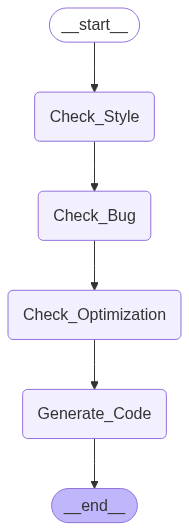

In [76]:
from IPython.display import Image, display

# 그래프 이미지 출력

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception as e:
    print("Mermaid 이미지 출력 실패:", e)
    print(app.get_graph(xray=True).draw_mermaid())  # 텍스트 대안 출력